<a href="https://colab.research.google.com/github/TEXTRAX28/Portfolio-Risk-Management/blob/main/Portfolio_Risk_Manager.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install yfinance pandas numpy


In [2]:
import yfinance as yf
import pandas as pd

tickers = ["BBCA.JK", "BBRI.JK", "TLKM.JK", "ASII.JK", "GOTO.JK"]
start = "2021-01-01"
end = "2026-01-01"

# Download stocks
data = yf.download(tickers, start=start, end=end, group_by="ticker", auto_adjust=False)

# Extract close prices of the stocks
close_prices = pd.concat({t: data[t]["Close"] for t in tickers}, axis=1)
close_prices.columns.name = None  # clean column name
close_prices.index.name = "Date"

# Download JKSE
jkse = yf.download("^JKSE", start=start, end=end, auto_adjust=False)

# Force JKSE close into a Series with a simple name (no MultiIndex columns)
jkse_close = jkse["Close"]
jkse_close.name = "JKSE"

prices = close_prices.join(jkse_close, how="inner")
prices.head()


prices.to_csv("idx_prices.csv")
print("Saved: idx_prices.csv")


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed

Saved: idx_prices.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from datetime import datetime

# Configure libraries
warnings.filterwarnings('ignore')
pd.set_option('display.precision', 4)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

# If configure success
print("All libraries imported sucessfully")

All libraries imported sucessfully


In [4]:
# Load CSV file (idx_prices.csv)
df = pd.read_csv('idx_prices.csv', index_col='Date', parse_dates=True)

print("Dataset Overview:")
print(f"Date Range: {df.index.min()} to {df.index.max()}")
print(f"Total Trading Days: {len(df)}")
print(f"Columns: {list(df.columns)}")

# Check missing values
print(f"\nMissing Values:\n{df.isnull().sum()}")

# Forward fill missing values
df = df.fillna(method='ffill')

# Separate stocks from benchmark
stock_columns = ['BBCA.JK', 'BBRI.JK', 'TLKM.JK', 'ASII.JK', 'GOTO.JK']
prices = df[stock_columns]
benchmark = df['^JKSE']

print(f"\nData loaded: {len(prices)} days, {len(stock_columns)} stocks")

print("\nFirst 5 rows:")
print(prices.head())

Dataset Overview:
Date Range: 2021-01-04 00:00:00 to 2025-12-30 00:00:00
Total Trading Days: 1205
Columns: ['BBCA.JK', 'BBRI.JK', 'TLKM.JK', 'ASII.JK', 'GOTO.JK', '^JKSE']

Missing Values:
BBCA.JK      0
BBRI.JK      0
TLKM.JK      0
ASII.JK      0
GOTO.JK    314
^JKSE        0
dtype: int64

Data loaded: 1205 days, 5 stocks

First 5 rows:
            BBCA.JK    BBRI.JK  TLKM.JK  ASII.JK  GOTO.JK
Date                                                     
2021-01-04   6835.0  3918.1143   3490.0   6225.0      NaN
2021-01-05   7090.0  3881.7512   3470.0   6175.0      NaN
2021-01-06   6945.0  3818.1160   3370.0   6150.0      NaN
2021-01-07   6965.0  3890.8418   3390.0   6075.0      NaN
2021-01-08   7050.0  3990.8401   3570.0   6425.0      NaN


Daily Returns Statistics:
        BBCA.JK     BBRI.JK   TLKM.JK   ASII.JK   GOTO.JK
count  890.0000  8.9000e+02  890.0000  890.0000  890.0000
mean     0.0002 -7.9668e-05   -0.0001    0.0001   -0.0012
std      0.0148  1.8442e-02    0.0184    0.0173    0.0404
min     -0.0853 -1.0123e-01   -0.0671   -0.0975   -0.2037
25%     -0.0086 -1.0072e-02   -0.0106   -0.0097   -0.0235
50%      0.0000  0.0000e+00    0.0000    0.0000    0.0000
75%      0.0080  9.2486e-03    0.0102    0.0090    0.0156
max      0.0762  9.2262e-02    0.1156    0.0995    0.3486


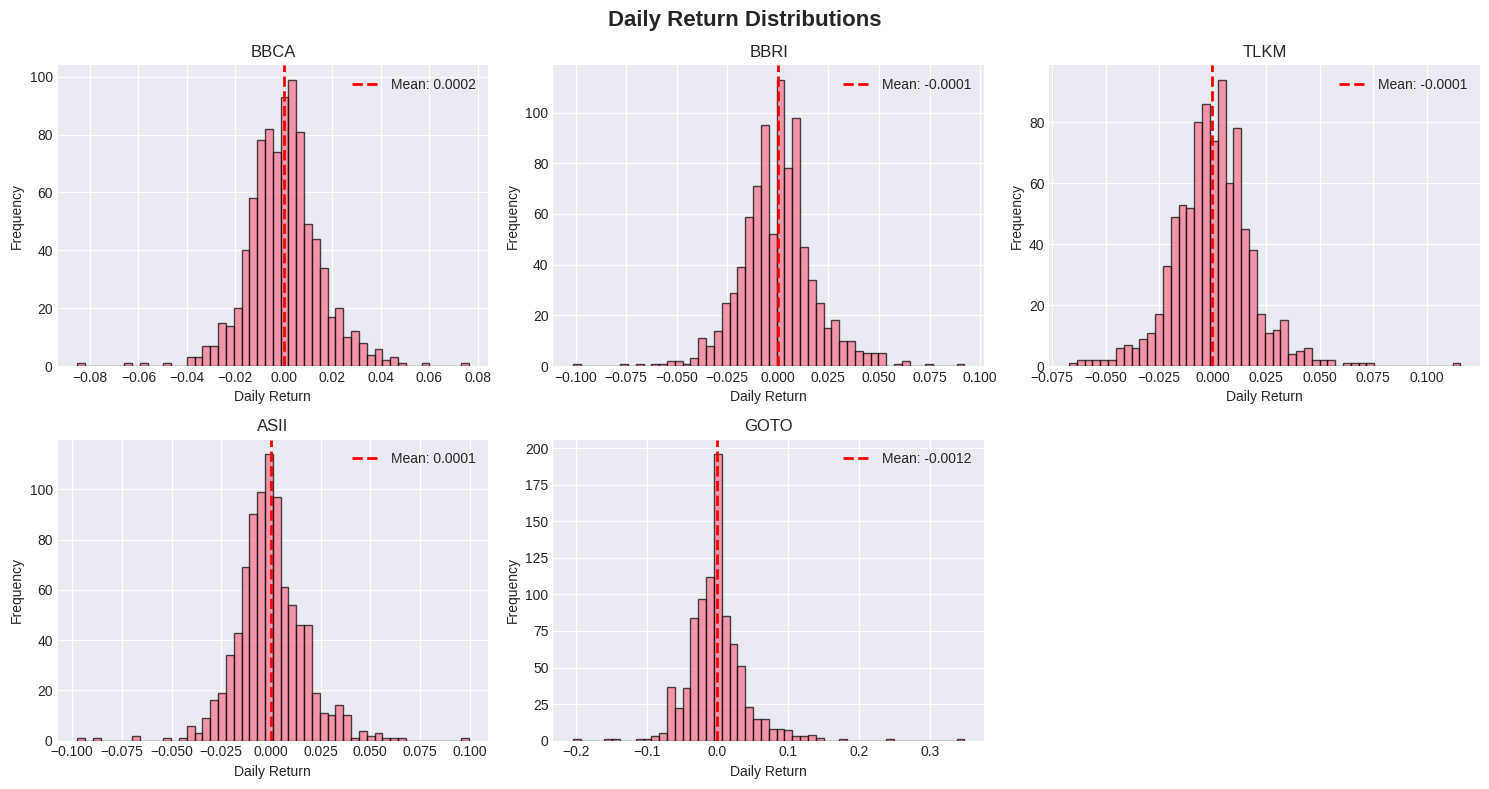

Returns are calculated for 890 days


In [5]:
# Calculate daily returns (percentage change)
returns = prices.pct_change().dropna()
benchmark_returns = benchmark.pct_change().dropna()

print("Daily Returns Statistics:")
print(returns.describe())

# Visualize return distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Daily Return Distributions', fontsize=16, fontweight='bold')

for idx, stock in enumerate(stock_columns):
    ax = axes[idx // 3, idx % 3] # Select subplot pos
    returns[stock].hist(bins=50, ax=ax, alpha=0.7, edgecolor='black') # Daily return of all stocks inside tickers
    mean_return = returns[stock].mean() # Compute mean
    ax.axvline(mean_return, color='red', linestyle='--', linewidth=2,
               label=f'Mean: {mean_return:.4f}')
    ax.set_title(stock.replace('.JK', ''))
    ax.set_xlabel('Daily Return')
    ax.set_ylabel('Frequency')
    ax.legend()

axes[1, 2].axis('off')
plt.tight_layout()
plt.show()

print(f"Returns are calculated for {len(returns)} days")

In [6]:
# This is an example of each weights for the stocks (EDIT THIS)
weights = {
    'BBCA.JK': 0.30,  # 30% Bank Central Asia
    'BBRI.JK': 0.25,  # 25% Bank Rakyat Indonesia
    'TLKM.JK': 0.20,  # 20% Telkom Indonesia
    'ASII.JK': 0.15,  # 15% Astra International
    'GOTO.JK': 0.10   # 10% GoTo Gojek Tokopedia
}

weight_array = np.array([weights[stock] for stock in stock_columns])

print("Portfolio Allocation:")
for stock, weight in weights.items():
    print(f"  {stock.replace('.JK', ''):6} : {weight*100:5.1f}%")

# Calculate portfolio returns
portfolio_returns = (returns * weight_array).sum(axis=1)

print(f"\nPortfolio Statistics:")
print(f"  Total Return: {(portfolio_returns + 1).prod() - 1:.2%}")
print(f"  Annualized Return: {portfolio_returns.mean() * 252:.2%}")
print(f"  Average Daily Return: {portfolio_returns.mean():.4%}")

# Calculate cumulative portfolio value (EDIT THIS)
initial_investment = 100_000_000  # This is an example of the inital invesment
portfolio_value = initial_investment * (1 + portfolio_returns).cumprod()

print(f"\nPortfolio Value:")
print(f"  Initial: Rp {initial_investment:,.0f}")
print(f"  Final: Rp {portfolio_value.iloc[-1]:,.0f}")
print(f"  Profit/Loss: Rp {portfolio_value.iloc[-1] - initial_investment:,.0f}")

Portfolio Allocation:
  BBCA   :  30.0%
  BBRI   :  25.0%
  TLKM   :  20.0%
  ASII   :  15.0%
  GOTO   :  10.0%

Portfolio Statistics:
  Total Return: -14.67%
  Annualized Return: -2.60%
  Average Daily Return: -0.0103%

Portfolio Value:
  Initial: Rp 100,000,000
  Final: Rp 85,331,314
  Profit/Loss: Rp -14,668,686


VOLATILITY ANALYSIS
Portfolio Volatility: 19.44%

Individual Stock Volatilities:
  BBCA   : 23.55%
  BBRI   : 29.28%
  TLKM   : 29.16%
  ASII   : 27.49%
  GOTO   : 64.11%

Average Stock Volatility: 34.72%
Diversification Benefit: 44.01%


CORRELATION MATRIX
         BBCA.JK  BBRI.JK  TLKM.JK  ASII.JK  GOTO.JK
BBCA.JK    1.000    0.513    0.340    0.279    0.104
BBRI.JK    0.513    1.000    0.272    0.320    0.122
TLKM.JK    0.340    0.272    1.000    0.207    0.073
ASII.JK    0.279    0.320    0.207    1.000    0.119
GOTO.JK    0.104    0.122    0.073    0.119    1.000


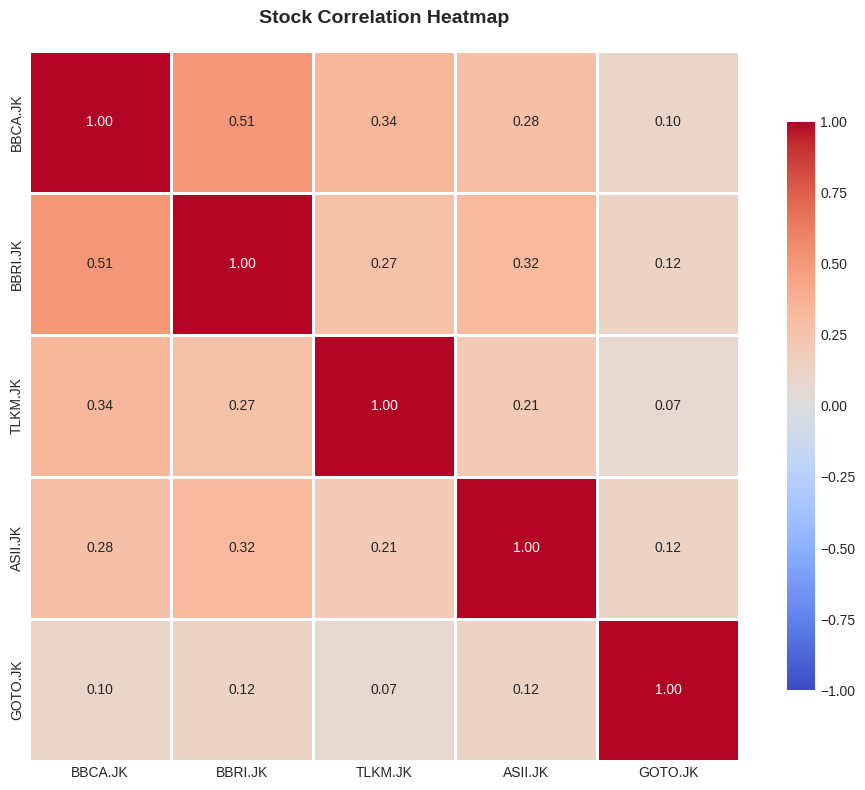

In [7]:
TRADING_DAYS = 252  # Trading days is about 250-252 in Indonesia

# RISK METRICS - VOLATILITY AND CORRELATION
# 1. VOLATILITY
portfolio_volatility = portfolio_returns.std() * np.sqrt(TRADING_DAYS)
individual_volatilities = returns.std() * np.sqrt(TRADING_DAYS)

print("VOLATILITY ANALYSIS")
print("=" * 20)
print(f"Portfolio Volatility: {portfolio_volatility:.2%}")
print(f"\nIndividual Stock Volatilities:")
for stock in stock_columns:
    print(f"  {stock.replace('.JK', ''):6} : {individual_volatilities[stock]:.2%}")

avg_stock_vol = individual_volatilities.mean()
diversification_benefit = (avg_stock_vol - portfolio_volatility) / avg_stock_vol
print(f"\nAverage Stock Volatility: {avg_stock_vol:.2%}")
print(f"Diversification Benefit: {diversification_benefit:.2%}")

# 2. CORRELATION MATRIX
correlation_matrix = returns.corr()

print("\n\nCORRELATION MATRIX")
print("=" * 20)
print(correlation_matrix.round(3))

# Visualize correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            fmt='.2f', vmin=-1, vmax=1)
plt.title('Stock Correlation Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [8]:
#RISK METRICS - MAX DRAWDOWN, VaR, CVaR
# 3. MAXIMUM DRAWDOWN
cumulative_returns = (1 + portfolio_returns).cumprod()
running_max = cumulative_returns.expanding().max()
drawdown = (cumulative_returns - running_max) / running_max
max_drawdown = drawdown.min()
max_drawdown_date = drawdown.idxmin()

print("MAXIMUM DRAWDOWN")
print("=" * 20)
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Date of Max Drawdown: {max_drawdown_date.strftime('%Y-%m-%d')}")

# 4. VALUE AT RISK (VaR) - 95% confidence
var_95_daily = np.percentile(portfolio_returns, 5)
var_95_monthly = var_95_daily * np.sqrt(21)

print("\n\nVALUE AT RISK (95% Confidence)")
print("=" * 20)
print(f"Daily VaR (95%): {var_95_daily:.2%}")
print(f"Monthly VaR (95%): {var_95_monthly:.2%}")
print(f"Expected Loss (95% confidence): Rp {var_95_daily * initial_investment:,.0f}/day")

# 5. CONDITIONAL VALUE AT RISK (CVaR)
cvar_95_daily = portfolio_returns[portfolio_returns <= var_95_daily].mean()

print("\n\nCONDITIONAL VALUE AT RISK (CVaR)")
print("=" * 20)
print(f"Daily CVaR (95%): {cvar_95_daily:.2%}")
print(f"Average Loss in Worst 5% Scenarios: Rp {cvar_95_daily * initial_investment:,.0f}/day")

MAXIMUM DRAWDOWN
Maximum Drawdown: -30.01%
Date of Max Drawdown: 2025-04-08


VALUE AT RISK (95% Confidence)
Daily VaR (95%): -1.84%
Monthly VaR (95%): -8.45%
Expected Loss (95% confidence): Rp -1,843,733/day


CONDITIONAL VALUE AT RISK (CVaR)
Daily CVaR (95%): -2.69%
Average Loss in Worst 5% Scenarios: Rp -2,693,304/day


In [9]:
# 6. BETA (vs IDX Composite)
covariance = portfolio_returns.cov(benchmark_returns)
benchmark_variance = benchmark_returns.var()
portfolio_beta = covariance / benchmark_variance

print("BETA ANALYSIS")
print("=" * 20)
print(f"Portfolio Beta (vs ^JKSE): {portfolio_beta:.3f}")
if portfolio_beta > 1:
    print(f"Interpretation: Portfolio is MORE volatile than market")
elif portfolio_beta < 1:
    print(f"Interpretation: Portfolio is LESS volatile than market")
else:
    print(f"Interpretation: Portfolio moves IN LINE with market")

# 7. SHARPE RATIO
risk_free_rate = 0.06  # 6% annual (Indonesia govt bonds)
daily_rf = risk_free_rate / TRADING_DAYS
excess_returns = portfolio_returns - daily_rf
sharpe_ratio = excess_returns.mean() / portfolio_returns.std() * np.sqrt(TRADING_DAYS)

print("\n\nSHARPE RATIO")
print("=" * 20)
print(f"Risk-Free Rate (Annual): {risk_free_rate:.1%}")
print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
if sharpe_ratio < 1:
    print("Interpretation: POOR - Returns don't justify risk")
elif sharpe_ratio < 2:
    print("Interpretation: GOOD - Acceptable risk-adjusted returns")
else:
    print("Interpretation: EXCELLENT - Strong risk-adjusted returns")

BETA ANALYSIS
Portfolio Beta (vs ^JKSE): 1.145
Interpretation: Portfolio is MORE volatile than market


SHARPE RATIO
Risk-Free Rate (Annual): 6.0%
Sharpe Ratio: -0.442
Interpretation: POOR - Returns don't justify risk


RISK CONTRIBUTION BY HOLDING
BBCA   :  27.3% (Weight: 30.0%)
BBRI   :  28.3% (Weight: 25.0%)
TLKM   :  17.8% (Weight: 20.0%)
ASII   :  11.4% (Weight: 15.0%)
GOTO   :  15.2% (Weight: 10.0%)


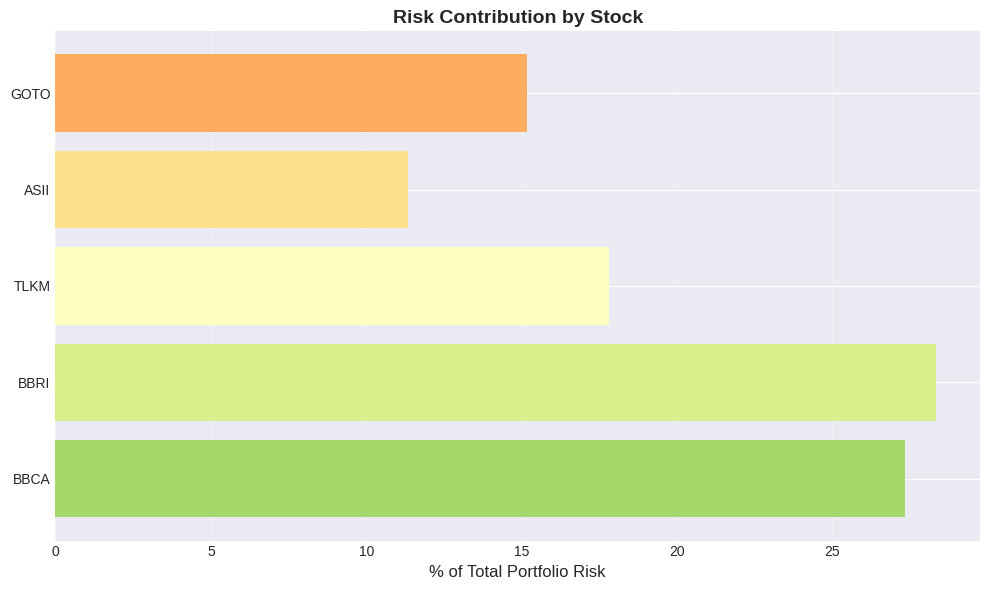

In [10]:
# 8. RISK CONTRIBUTION BY HOLDING
portfolio_std = portfolio_returns.std()
risk_contributions = {}

for stock in stock_columns:
    stock_weight = weights[stock]
    stock_return = returns[stock]
    correlation_with_portfolio = stock_return.corr(portfolio_returns)
    stock_volatility = stock_return.std()

    marginal_contrib = (stock_weight * stock_volatility * correlation_with_portfolio) / portfolio_std
    risk_contributions[stock] = marginal_contrib

# Normalize to percentages
total_risk = sum(risk_contributions.values())
risk_contribution_pct = {k: v/total_risk for k, v in risk_contributions.items()}

print("RISK CONTRIBUTION BY HOLDING")
print("=" * 20)
for stock in stock_columns:
    print(f"{stock.replace('.JK', ''):6} : {risk_contribution_pct[stock]:6.1%} "
          f"(Weight: {weights[stock]:5.1%})")

# Visualize
stocks_short = [s.replace('.JK', '') for s in stock_columns]
risk_pcts = [risk_contribution_pct[s] * 100 for s in stock_columns]

plt.figure(figsize=(10, 6))
plt.barh(stocks_short, risk_pcts, color=plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(stocks_short))))
plt.xlabel('% of Total Portfolio Risk', fontsize=12)
plt.title('Risk Contribution by Stock', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
# Stress test
# Categorize stocks by sector
stock_sectors = {
    'BBCA.JK': 'financial',
    'BBRI.JK': 'financial',
    'TLKM.JK': 'telecom',
    'ASII.JK': 'industrial',
    'GOTO.JK': 'telecom'
}

# Define scenarios
scenarios = {
    'Market Crash (-20%)': {
        'BBCA.JK': -0.24, 'BBRI.JK': -0.24, 'TLKM.JK': -0.16,
        'ASII.JK': -0.20, 'GOTO.JK': -0.16
    },
    'Banking Crisis (-30%)': {
        'BBCA.JK': -0.30, 'BBRI.JK': -0.30, 'TLKM.JK': -0.10,
        'ASII.JK': -0.15, 'GOTO.JK': -0.10
    },
    'Currency Shock (-15%)': {
        'BBCA.JK': -0.15, 'BBRI.JK': -0.15, 'TLKM.JK': -0.15,
        'ASII.JK': -0.15, 'GOTO.JK': -0.15
    },
    'Rate Hike (+5%)': {
        'BBCA.JK': -0.08, 'BBRI.JK': -0.08, 'TLKM.JK': -0.12,
        'ASII.JK': -0.10, 'GOTO.JK': -0.12
    }
}

stress_results = {}

for scenario_name, shocks in scenarios.items():
    portfolio_impact = sum(shocks[stock] * weights[stock] for stock in stock_columns)
    new_value = initial_investment * (1 + portfolio_impact)
    stress_results[scenario_name] = portfolio_impact

    print(f"\n{scenario_name}")
    print(f"  Portfolio Impact: {portfolio_impact:+.1%}")
    print(f"  Portfolio Value: Rp {new_value:,.0f}")
    print(f"  Loss Amount: Rp {portfolio_impact * initial_investment:,.0f}")


Market Crash (-20%)
  Portfolio Impact: -21.0%
  Portfolio Value: Rp 79,000,000
  Loss Amount: Rp -21,000,000

Banking Crisis (-30%)
  Portfolio Impact: -21.8%
  Portfolio Value: Rp 78,250,000
  Loss Amount: Rp -21,750,000

Currency Shock (-15%)
  Portfolio Impact: -15.0%
  Portfolio Value: Rp 85,000,000
  Loss Amount: Rp -15,000,000

Rate Hike (+5%)
  Portfolio Impact: -9.5%
  Portfolio Value: Rp 90,500,000
  Loss Amount: Rp -9,500,000


MONTE CARLO SIMULATION (1 Year Forecast)
Historical Mean Daily Return: -0.0103%
Historical Daily Volatility: 1.2245%

Running 10,000 simulations...

Simulation Results:
  Expected Return (Median): -4.5%
  Best Case (95th percentile): +31.0%
  Worst Case (5th percentile): -30.9%
  Probability of Profit: 40.5%

Value Projections:
  Expected: Rp 95,472,768
  Best: Rp 130,982,040
  Worst: Rp 69,109,369


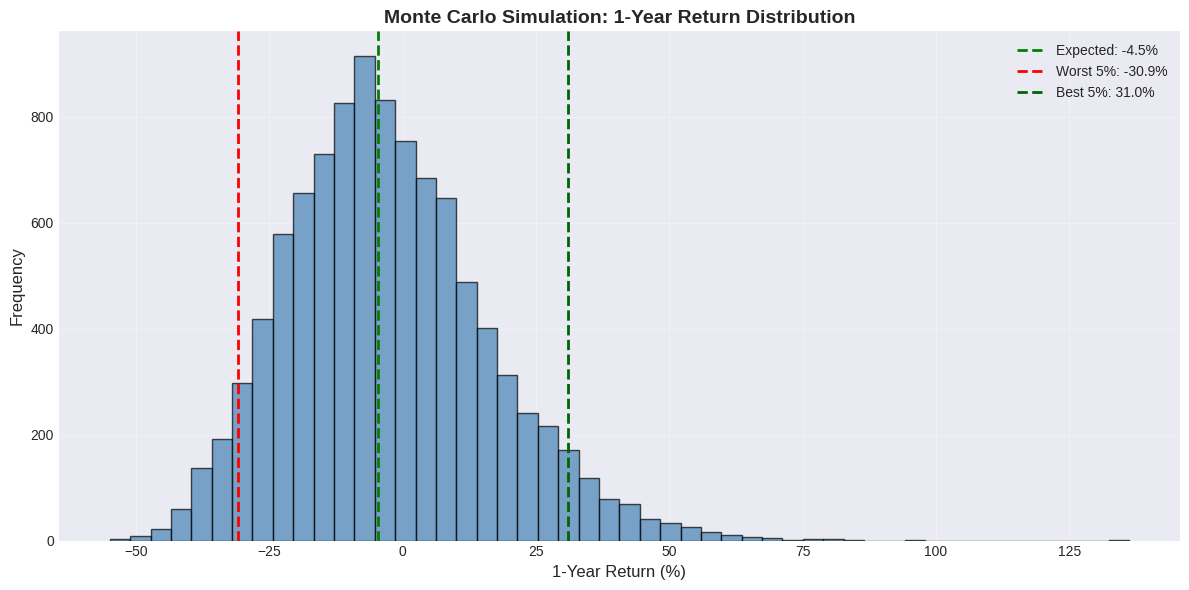

In [12]:
print("MONTE CARLO SIMULATION (1 Year Forecast)")
print("=" * 60)

# Simulation parameters
num_simulations = 10000
forecast_days = 252  # 1 year

mean_return = portfolio_returns.mean()
std_return = portfolio_returns.std()

print(f"Historical Mean Daily Return: {mean_return:.4%}")
print(f"Historical Daily Volatility: {std_return:.4%}")
print(f"\nRunning {num_simulations:,} simulations...")

# Run simulations
simulation_results = []

for i in range(num_simulations):
    daily_returns = np.random.normal(mean_return, std_return, forecast_days)
    final_value = initial_investment * np.prod(1 + daily_returns)
    final_return = (final_value - initial_investment) / initial_investment
    simulation_results.append(final_return)

simulation_results = np.array(simulation_results)

# Statistics
median_return = np.median(simulation_results)
best_case = np.percentile(simulation_results, 95)
worst_case = np.percentile(simulation_results, 5)
prob_positive = (simulation_results > 0).sum() / num_simulations

print(f"\nSimulation Results:")
print(f"  Expected Return (Median): {median_return:+.1%}")
print(f"  Best Case (95th percentile): {best_case:+.1%}")
print(f"  Worst Case (5th percentile): {worst_case:+.1%}")
print(f"  Probability of Profit: {prob_positive:.1%}")
print(f"\nValue Projections:")
print(f"  Expected: Rp {initial_investment * (1 + median_return):,.0f}")
print(f"  Best: Rp {initial_investment * (1 + best_case):,.0f}")
print(f"  Worst: Rp {initial_investment * (1 + worst_case):,.0f}")

# Visualize
plt.figure(figsize=(12, 6))
plt.hist(simulation_results * 100, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
plt.axvline(median_return * 100, color='green', linestyle='--', linewidth=2,
            label=f'Expected: {median_return:.1%}')
plt.axvline(worst_case * 100, color='red', linestyle='--', linewidth=2,
            label=f'Worst 5%: {worst_case:.1%}')
plt.axvline(best_case * 100, color='darkgreen', linestyle='--', linewidth=2,
            label=f'Best 5%: {best_case:.1%}')
plt.xlabel('1-Year Return (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Monte Carlo Simulation: 1-Year Return Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Dashboard saved as 'portfolio_risk_dashboard.png'


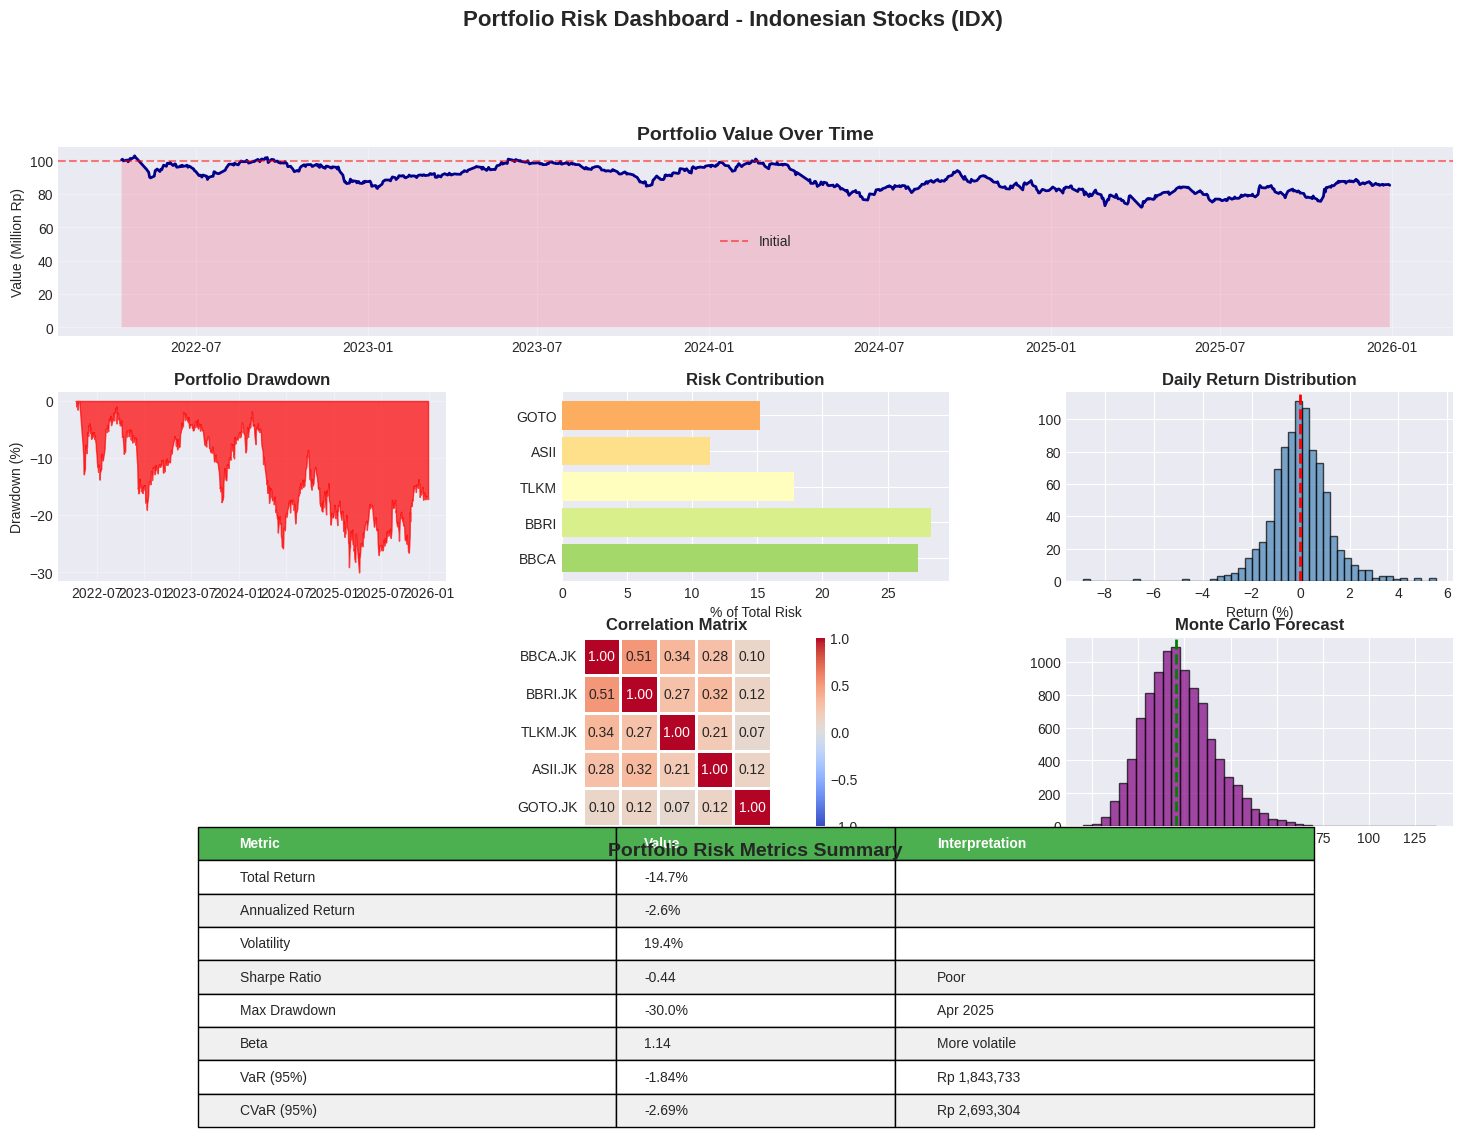

In [13]:
# Create comprehensive dashboard
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# 1. Portfolio Value Over Time
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(portfolio_value.index, portfolio_value.values / 1e6, linewidth=2, color='darkblue')
ax1.fill_between(portfolio_value.index, portfolio_value.values / 1e6, alpha=0.3)
ax1.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Value (Million Rp)', fontsize=10)
ax1.grid(alpha=0.3)
ax1.axhline(initial_investment / 1e6, color='red', linestyle='--', alpha=0.5, label='Initial')
ax1.legend()

# 2. Drawdown Chart
ax2 = fig.add_subplot(gs[1, 0])
ax2.fill_between(drawdown.index, drawdown.values * 100, 0, alpha=0.7, color='red')
ax2.set_title('Portfolio Drawdown', fontsize=12, fontweight='bold')
ax2.set_ylabel('Drawdown (%)', fontsize=10)
ax2.grid(alpha=0.3)

# 3. Risk Contribution
ax3 = fig.add_subplot(gs[1, 1])
stocks_short = [s.replace('.JK', '') for s in stock_columns]
risk_pcts = [risk_contribution_pct[s] * 100 for s in stock_columns]
ax3.barh(stocks_short, risk_pcts, color=plt.cm.RdYlGn_r(np.linspace(0.3, 0.7, len(stocks_short))))
ax3.set_title('Risk Contribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('% of Total Risk', fontsize=10)

# 4. Return Distribution
ax4 = fig.add_subplot(gs[1, 2])
ax4.hist(portfolio_returns * 100, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
ax4.axvline(portfolio_returns.mean() * 100, color='red', linestyle='--', linewidth=2)
ax4.set_title('Daily Return Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('Return (%)', fontsize=10)

# 5. Correlation Heatmap
ax5 = fig.add_subplot(gs[2, :2])
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, ax=ax5, vmin=-1, vmax=1)
ax5.set_title('Correlation Matrix', fontsize=12, fontweight='bold')

# 6. Monte Carlo Results
ax6 = fig.add_subplot(gs[2, 2])
ax6.hist(simulation_results * 100, bins=40, alpha=0.7, edgecolor='black', color='purple')
ax6.axvline(median_return * 100, color='green', linestyle='--', linewidth=2)
ax6.set_title('Monte Carlo Forecast', fontsize=12, fontweight='bold')
ax6.set_xlabel('Return (%)', fontsize=10)

# 7. Summary Table
ax7 = fig.add_subplot(gs[3, :])
ax7.axis('off')

metrics_data = [
    ['Metric', 'Value', 'Interpretation'],
    ['Total Return', f"{(portfolio_returns + 1).prod() - 1:.1%}", ''],
    ['Annualized Return', f"{portfolio_returns.mean() * 252:.1%}", ''],
    ['Volatility', f"{portfolio_volatility:.1%}", ''],
    ['Sharpe Ratio', f"{sharpe_ratio:.2f}", 'Good' if 1 < sharpe_ratio < 2 else 'Excellent' if sharpe_ratio >= 2 else 'Poor'],
    ['Max Drawdown', f"{max_drawdown:.1%}", max_drawdown_date.strftime('%b %Y')],
    ['Beta', f"{portfolio_beta:.2f}", 'More volatile' if portfolio_beta > 1 else 'Less volatile'],
    ['VaR (95%)', f"{var_95_daily:.2%}", f"Rp {abs(var_95_daily * initial_investment):,.0f}"],
    ['CVaR (95%)', f"{cvar_95_daily:.2%}", f"Rp {abs(cvar_95_daily * initial_investment):,.0f}"],
]

table = ax7.table(cellText=metrics_data, cellLoc='left', loc='center', colWidths=[0.3, 0.2, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(3):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(1, len(metrics_data)):
    for j in range(3):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

ax7.set_title('Portfolio Risk Metrics Summary', fontsize=14, fontweight='bold', pad=20)

plt.suptitle('Portfolio Risk Dashboard - Indonesian Stocks (IDX)', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('portfolio_risk_dashboard.png', dpi=300, bbox_inches='tight')
print("\nDashboard saved as 'portfolio_risk_dashboard.png'")
plt.show()

In [15]:
report = f"""
{'='*70}
         PORTFOLIO RISK ANALYSIS - EXECUTIVE SUMMARY
{'='*70}

Analysis Date: {datetime.now().strftime('%B %d, %Y')}
Portfolio: Indonesian Equity Portfolio (IDX)
Period: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}
Initial Investment: Rp {initial_investment:,.0f}

{'='*70}
PERFORMANCE METRICS
{'='*70}

Total Return:                {(portfolio_returns + 1).prod() - 1:>10.1%}
Annualized Return:           {portfolio_returns.mean() * 252:>10.1%}
Current Portfolio Value:     Rp {portfolio_value.iloc[-1]:>12,.0f}
Profit/Loss:                 Rp {portfolio_value.iloc[-1] - initial_investment:>12,.0f}

{'='*70}
RISK METRICS
{'='*70}

Annualized Volatility:       {portfolio_volatility:>10.1%}
Maximum Drawdown:            {max_drawdown:>10.1%} ({max_drawdown_date.strftime('%b %Y')})
Sharpe Ratio:                {sharpe_ratio:>10.2f}
Beta (vs JKSE):              {portfolio_beta:>10.2f}

{'='*70}
VALUE AT RISK (95% Confidence)
{'='*70}

Daily VaR:                   {var_95_daily:>10.2%}
Daily CVaR:                  {cvar_95_daily:>10.2%}
Monthly VaR:                 {var_95_monthly:>10.2%}

Expected Loss:               Rp {abs(var_95_daily * initial_investment):>12,.0f}/day
Worst 5% avg:                Rp {abs(cvar_95_daily * initial_investment):>12,.0f}/day

{'='*70}
DIVERSIFICATION ANALYSIS
{'='*70}

Avg Stock Volatility:        {avg_stock_vol:>10.1%}
Portfolio Volatility:        {portfolio_volatility:>10.1%}
Diversification Benefit:     {diversification_benefit:>10.1%}

{'='*70}
RISK CONTRIBUTION BY HOLDING
{'='*70}
"""

for stock in stock_columns:
    stock_name = stock.replace('.JK', '')
    risk_pct = risk_contribution_pct[stock]
    weight_pct = weights[stock]
    report += f"{stock_name:6} : {risk_pct:5.1%} of risk ({weight_pct:5.1%} weight)\n"

report += f"""
{'='*70}
STRESS TEST RESULTS
{'='*70}
"""

for scenario, impact in stress_results.items():
    new_val = initial_investment * (1 + impact)
    report += f"{scenario:25} : {impact:>7.1%}  (Rp {new_val:>12,.0f})\n"

report += f"""
{'='*70}
MONTE CARLO (1 Year, {num_simulations:,} runs)
{'='*70}

Best Case (95th):            {best_case:>10.1%}
Expected (median):           {median_return:>10.1%}
Worst Case (5th):            {worst_case:>10.1%}
Probability of Profit:       {prob_positive:>10.1%}

{'='*70}
KEY INSIGHTS
{'='*70}

Portfolio volatility ({portfolio_volatility:.1%}) < Avg stock volatility ({avg_stock_vol:.1%})
Diversification benefit: {diversification_benefit:.1%}
Sharpe ratio: {sharpe_ratio:.2f}
"""

if risk_contribution_pct['BBCA.JK'] + risk_contribution_pct['BBRI.JK'] > 0.7:
    report += "\nHigh banking sector concentration (>70% risk)\n"

if max_drawdown < -0.20:
    report += f"Significant drawdown: {max_drawdown:.1%}\n"

report += """
"""
{'='*70}

print(report)

# Save report
with open('portfolio_risk_report.txt', 'w') as f:
    f.write(report)
print("\nReport saved as 'portfolio_risk_report.txt'")


         PORTFOLIO RISK ANALYSIS - EXECUTIVE SUMMARY

Analysis Date: January 19, 2026
Portfolio: Indonesian Equity Portfolio (IDX)
Period: 2021-01-04 to 2025-12-30
Initial Investment: Rp 100,000,000

PERFORMANCE METRICS

Total Return:                    -14.7%
Annualized Return:                -2.6%
Current Portfolio Value:     Rp   85,331,314
Profit/Loss:                 Rp  -14,668,686

RISK METRICS

Annualized Volatility:            19.4%
Maximum Drawdown:                -30.0% (Apr 2025)
Sharpe Ratio:                     -0.44
Beta (vs JKSE):                    1.14

VALUE AT RISK (95% Confidence)

Daily VaR:                       -1.84%
Daily CVaR:                      -2.69%
Monthly VaR:                     -8.45%

Expected Loss:               Rp    1,843,733/day
Worst 5% avg:                Rp    2,693,304/day

DIVERSIFICATION ANALYSIS

Avg Stock Volatility:             34.7%
Portfolio Volatility:             19.4%
Diversification Benefit:          44.0%

RISK CONTRIBUTION BY H